# Computer Assignment 4: CNN Segmentation
## Alaqian Zafar - aaz7118

## Table of Contents
- <a href='#p1a'>Part (a)</a>
- <a href='#p1b'>Part (b)</a>
- <a href='#p1c'>Part (c)</a>
    - [Architecture](#Architecture)
    - [Loss Function](#Loss-Function)
- <a href='#p1d'>Part (d)</a>
- <a href='#p2a'>Part (e)</a>
- <a href='#p2b'>Part (f)</a>
- <a href='#p2c'>Part (g)</a>

In [7]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm

%matplotlib inline

In [8]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/ECE-GY 6123 Image and Video Processing/Computer Assignments/CA04/archive'
except:
    path = 'archive'

<a id='p1a'></a>
##### (a) Cut the FudanPed dataset into an 80-10-10 train-val-test split.

[Table of Contents](#Table-of-Contents)

In [9]:
image_paths = sorted([os.path.join(path, "PNGImages", image) for image in os.listdir(os.path.join(path, "PNGImages"))])
mask_paths = sorted([os.path.join(path, "PedMasks", mask) for mask in os.listdir(os.path.join(path, "PedMasks"))])

indices = list(range(len(image_paths)))
train_indices = random.sample(indices, k=int(len(indices)*0.8))
val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))
test_indices = list(set(indices)-set(train_indices)-set(val_indices))

train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]
test_image_paths = [image_paths[i] for i in test_indices]
test_mask_paths = [mask_paths[i] for i in test_indices]

def square_pad(image):
    h_diff = max(image.shape) - image.shape[0]
    w_diff = max(image.shape) - image.shape[1]

    top = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    bottom = h_diff // 2
    left = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2    
    right = w_diff // 2
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded_image, image.shape

def remove_pad(padded_image, original_shape):
    h_diff = padded_image.shape[0] - original_shape[0]
    w_diff = padded_image.shape[1] - original_shape[1]

    h_start = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    h_end = padded_image.shape[0] - h_diff // 2
    w_start = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2
    w_end = padded_image.shape[1] - w_diff // 2

    return padded_image[h_start:h_end, w_start:w_end]

class PennFudanDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_size=None, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], 0)
        # Set all values greater-than or equal-to 1 to 255.
        mask = np.clip(mask, 0, 1)*255
        if self.transform or self.image_size:
            merged_image = np.concatenate((image, mask[:, :, None]), axis=2)
            merged_image, merged_shape = square_pad(merged_image)
            merged_image = transforms.ToTensor()(merged_image)
            if self.transform:
                merged_image = self.transform(merged_image)
            if self.image_size:
                merged_image = transforms.Resize((self.image_size, self.image_size))(merged_image)
            image = merged_image[:3, :, :]
            mask = merged_image[3, :, :].unsqueeze(0)
            return image, mask, merged_shape
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
        return image, mask

<a id='p1b'></a>
##### (b) Apply data augmentation to your dataset during training and show an example of your data augmentation in your report.

[Table of Contents](#Table-of-Contents)

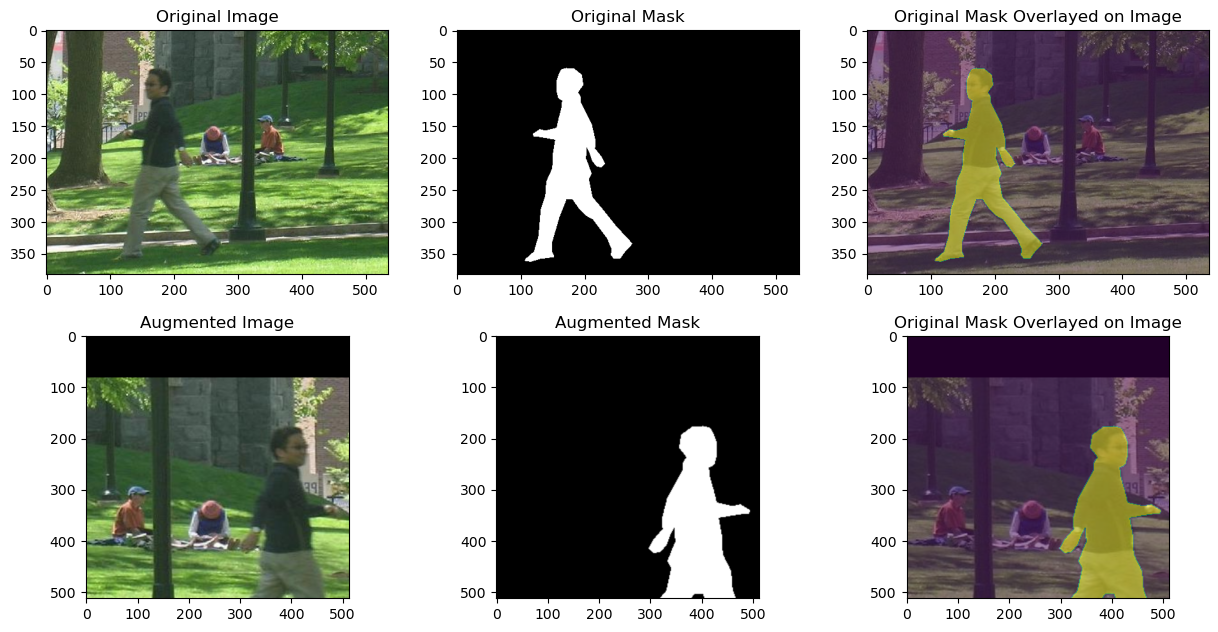

In [23]:
# Plot a subplot of the original and the augmented image and mask
train_dataset = PennFudanDataset(train_image_paths, train_mask_paths)
image, mask = train_dataset[0]
fig, ax = plt.subplots(2, 3, figsize=(15, 7.5))
ax[0,0].imshow(image.permute(1, 2, 0))
ax[0,0].set_title("Original Image")
ax[0,1].imshow(mask.squeeze(), cmap="gray")
ax[0,1].set_title("Original Mask")
ax[0,2].imshow(image.permute(1, 2, 0))
ax[0,2].imshow(mask.squeeze(), alpha=0.5)
ax[0,2].set_title("Original Mask Overlayed on Image")

image_size = 256

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(256)
    ])
augmented_train_dataset = PennFudanDataset(
    train_image_paths, 
    train_mask_paths,
    transform=augmentation)
image, mask, _ = augmented_train_dataset[0]
ax[1,0].imshow(image.permute(1, 2, 0))
ax[1,0].set_title("Augmented Image")
ax[1,1].imshow(mask.squeeze(),cmap="gray")
ax[1,1].set_title("Augmented Mask")
ax[1,2].imshow(image.permute(1, 2, 0))
ax[1,2].imshow(mask.squeeze(), alpha=0.5)
ax[1,2].set_title("Original Mask Overlayed on Image")

batchsize = 8

train_loader = DataLoader(augmented_train_dataset, batch_size=batchsize, shuffle=True)

test_dataset = PennFudanDataset(test_image_paths, test_mask_paths, image_size=image_size)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

val_dataset = PennFudanDataset(val_image_paths, val_mask_paths, image_size=image_size)
val_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

<a id='p1c'></a>
##### (c) Implement and train a CNN for binary segmentation on your train split. Describe your network architecture, loss function, and any training hyper-parameters. You may implement any architecture you'd like, **but the implementation must be your own code.**

[Table of Contents](#Table-of-Contents)

#### Architecture

`x` (input) → `Conv_BN_ReLU1` → `Downsample1` → `x1` → `x2` → `Conv_BN_ReLU2` → `x3` → `Downsample2` → `x4` → `Conv_BN_ReLU3` → `x5` → `Upsample1` → `x6` → `cat(x3)` → `x7` → `Conv_BN_ReLU4` → `x8` → `Upsamle2` → `x9` → `cat(x1)` → `x10` → `Conv_BN_ReLU5` → `x11` → `conv6` → `x12` → `sigmoid` → `x13` (output)

![Architecture](UNET.png)

In [ ]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.Conv_BN_ReLU1 = self._Conv_BN_ReLU(3, 16)
        self.Downsample1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU2 = self._Conv_BN_ReLU(16, 32)
        self.Downsample2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU3 = self._Conv_BN_ReLU(32, 32)
        self.Upsample1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU4 = self._Conv_BN_ReLU(64, 16)
        self.Upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU5 = self._Conv_BN_ReLU(32, 16)
        self.Conv6 = nn.Conv2d(16, 1, kernel_size=1)

    def _Conv_BN_ReLU(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x1 = self.Conv_BN_ReLU1(x) # 3x128x128 -> 16x128x128
        x2 = self.Downsample1(x1) # 16x128x128 -> 16x64x64
        x3 = self.Conv_BN_ReLU2(x2) # 16x64x64 -> 32x64x64
        x4 = self.Downsample2(x3) # 32x64x64 -> 32x32x32
        x5 = self.Conv_BN_ReLU3(x4) # 32x32x32 -> 32x32x32
        x6 = self.Upsample1(x5) # 32x32x32 -> 32x64x64
        x7 = torch.cat((x6, x3), dim=1) # 32x64x64 + 32x64x64 -> 64x64x64
        x8 = self.Conv_BN_ReLU4(x7) # 64x64x64 -> 16x64x64
        x9 = self.Upsample2(x8) # 16x64x64 -> 16x128x128
        x10 = torch.cat((x9, x1), dim=1) # 16x128x128 + 16x128x128 -> 32x128x128
        x11 = self.Conv_BN_ReLU5(x10) # 32x128x128 -> 16x128x128
        x12 = self.Conv6(x11) # 16x128x128 -> 1x128x128
        x13 = torch.sigmoid(x12) # 1x128x128 -> 1x128x128
        return x13

#### Loss Function

[Table of Contents](#Table-of-Contents)

In [ ]:
def dice_coefficient(output, ground_truth):
    numerical_stability = 1.
    output = output.view(-1)
    ground_truth = ground_truth.view(-1)
    intersection = (output * ground_truth).sum()
    return (2. * intersection + numerical_stability) / (output.sum() + ground_truth.sum() + numerical_stability)

class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()
    
    def forward(self, output, ground_truth):
        return 1 - dice_coefficient(output, ground_truth)

#### Training

[Table of Contents](#Table-of-Contents)

In [ ]:
def save_checkpoint(filename, model, optimizer, epoch, val_loss):
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "loss": val_loss}, filename)
    
def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    return model, optimizer, epoch, loss

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, mask[:,None,:,:])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, mask in val_loader:
            image = image.to(device)
            mask = mask.to(device)
            pred = model(image)
            loss = criterion(pred, mask[:,None,:,:])
            val_loss += loss.item()
    return val_loss / len(val_loader)


NUM_EPOCHS = 50
learning_rate=0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET().to(device)
criterion = SoftDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
checkpoint_dir = "./checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

if os.path.exists(checkpoint_path):
    model, optimizer, start_epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded: start epoch = {}, val loss = {}".format(start_epoch, val_loss))
else:
    start_epoch = 0
    val_loss = np.inf

train_losses = []
val_losses = []
for epoch in range(start_epoch, start_epoch+NUM_EPOCHS):
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}/{}...".format(epoch+1, start_epoch+NUM_EPOCHS),
            "Train Loss: {:.4f}...".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)


In [ ]:
# Use the model on the test set and visualize the results
model.eval()
with torch.no_grad():
    image, mask = next(iter(test_loader))
    image = image.to(device)
    mask = mask.to(device)
    pred = model(image)
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()
    image = image.cpu().numpy()
    pred = np.squeeze(pred, axis=1)
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(image[3].transpose(1, 2,0))
    ax[0].set_title("Image")
    ax[1].imshow(mask[3], cmap="gray")
    ax[1].set_title("Mask")
    ax[2].imshow(pred[3], cmap="gray")
    ax[2].set_title("Prediction")
    plt.show()

    for image in os.listdir("./out_of_distribution_images"):
        image = cv2.imread(os.path.join("./out_of_distribution_images", image))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = image.transpose(2, 0, 1)
        image = image / 255
        image = torch.from_numpy(image).float()
        image = image.to(device)
        pred = model(image[None, ...])
        pred = pred.cpu().numpy()
        pred = np.squeeze(pred, axis=1)
        plt.subplot(1, 2, 1)
        plt.imshow(image.cpu().numpy().transpose(1, 2, 0))
        plt.subplot(1, 2, 2)
        plt.imshow(pred[0], cmap="gray")
        plt.show()

The model is trained for 40 epochs and the results are shown below. The model is able to detect the edges of the objects in the image and the mask. The model is not able to detect the objects completely. This is because the dataset is very small and the model is not able to learn the features of the objects. The model is also not able to detect the objects that are not present in the training set.


<a id='p1d'></a>
##### (d) Report training loss, validation loss, and validation DICE curves. Comment on any overfitting or underfitting observed.

[Table of Contents](#Table-of-Contents)

<a id='p2a'></a>
##### (e) Report the average dice score over your test-set. **You should be able to achieve a score of around 0.7 or better**.

[Table of Contents](#Table-of-Contents)

<a id='p2b'></a>
##### (f) Show at least 3 example segmentations (i.e. show the RGB image, mask, and RGB image X mask for 3 samples) from your training data and 3 from your testing data. Comment on the generalization capabilities of your trained network.

[Table of Contents](#Table-of-Contents)

<a id='p2c'></a>
##### (g) Show at least 1 example segmentation on an input image **<ins>not</ins> from the FudanPed dataset**. Again, comment on the generalization capabilities of your network with respect to this "out-of-distribution" image.

[Table of Contents](#Table-of-Contents)

In [ ]:
# Create a README.md from this notebook
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to html --template lab
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to markdown --output README.md